In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models

### Data + EDA

In [7]:
# Get penguin data
penguins = pd.read_csv('./data/penguins_size.csv')

# Drop rows with NAs
penguins = penguins.dropna(axis=0)

In [12]:
# Summary
penguins[['species', 'body_mass_g']].groupby('species').agg(['mean', 'std', 'count'])

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5090.625000  499.759002   120

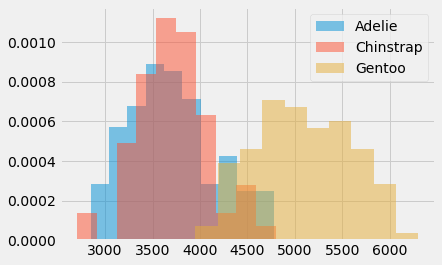

In [14]:
for species in penguins.species.unique():
    
    plt.hist(
        penguins[penguins['species'] == species]['body_mass_g'].values, 
        alpha=.5, 
        label=species,
        density=True)
    
plt.legend()
plt.show()

### Model - single specie

In [17]:
# Get observations
adelie_mass_obs = penguins[penguins.species == 'Adelie']['body_mass_g'].values

In [18]:
# Model
with pm.Model() as model_adelie_mass:
    
    # Prior params
    sigma = pm.HalfStudentT('sigma', 100, 2000)
    mu = pm.Normal('mu', 4000, 3000)
    
    # Likelihood X prior
    mass = pm.Normal(
        'mass', 
        mu=mu,
        sigma=sigma,
        observed=adelie_mass_obs)
    
    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(chains=4)
    
    inference_data_adelie_mass = az.from_pymc3(
        prior=prior,
        trace=trace)

C:\Users\aleks\AppData\Local\Temp\ipykernel_47328\3149164145.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(chains=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


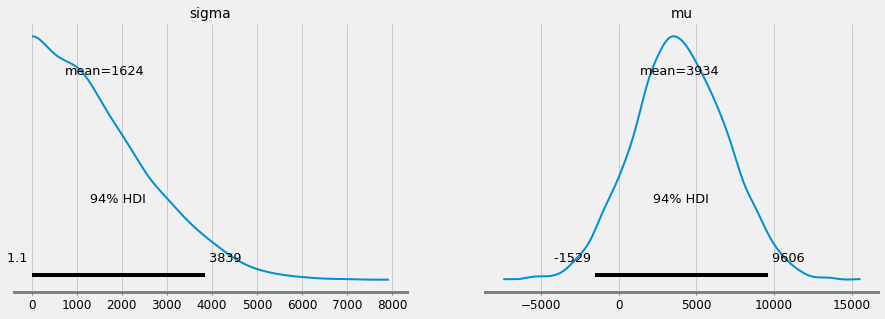

In [25]:
# Plot prior
az.plot_posterior(
    inference_data_adelie_mass.prior, 
    var_names=['sigma', 'mu'], 
    textsize=12, 
    lw=2
)
plt.show()

Prior for $\mu$ might be too wide as it have negative values, but should be fine in this case.

In [27]:
# Summarize
az.summary(inference_data_adelie_mass).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3705.5,38.9,3633.0,3779.1,0.7,0.5,3376.0,2612.0,1.0
sigma,461.9,27.3,410.9,513.2,0.5,0.3,3111.0,2528.0,1.0


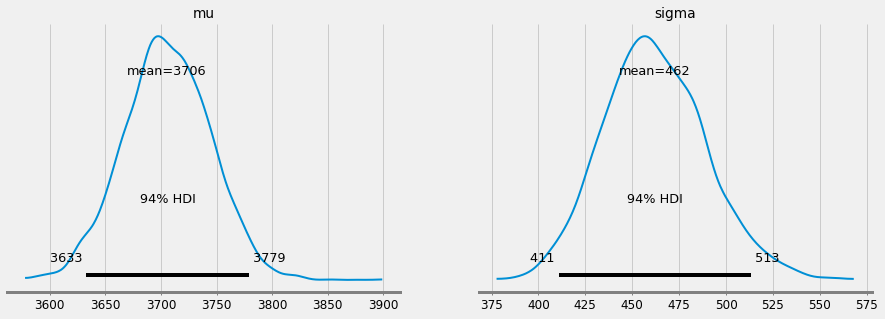

In [29]:
# Plot posterior
az.plot_posterior(
    inference_data_adelie_mass, 
    textsize=12, 
    lw=2
)
plt.show()

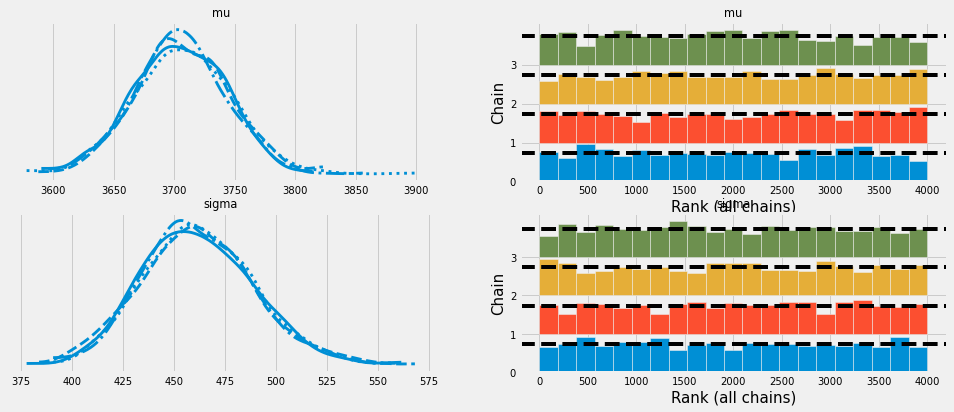

In [39]:
# Plot traces
az.plot_trace(
    inference_data_adelie_mass, 
    compact=True, 
    figsize=(15, 6),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

Chains and ranks look good!

### Model - all species

In [46]:
# Get n categories (species)
N_SPECIES = penguins['species'].unique().shape[0]

# Cast species to pd.Categorical
all_species = pd.Categorical(penguins['species'])

# Model
with pm.Model() as model_all_mass:
    
    # We'll add shape parameter now to take groupings into account
    # Prior params
    sigma = pm.HalfStudentT('sigma', 100, 2000, shape=N_SPECIES)
    mu = pm.Normal('mu', 4000, 3000, shape=N_SPECIES)
    
    # Likelihood X prior
    mass = pm.Normal(
        'mass', 
        mu=mu[all_species.codes],
        sigma=sigma[all_species.codes],
        observed=penguins['body_mass_g'])
    
    trace = pm.sample()
    
    inference_data_all_mass = az.from_pymc3(
        trace=trace,
        coords={
            'mu_dim_0': all_species.categories,
            'sigma_dim_0': all_species.categories
        }
    )

C:\Users\aleks\AppData\Local\Temp\ipykernel_47328\1332597313.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


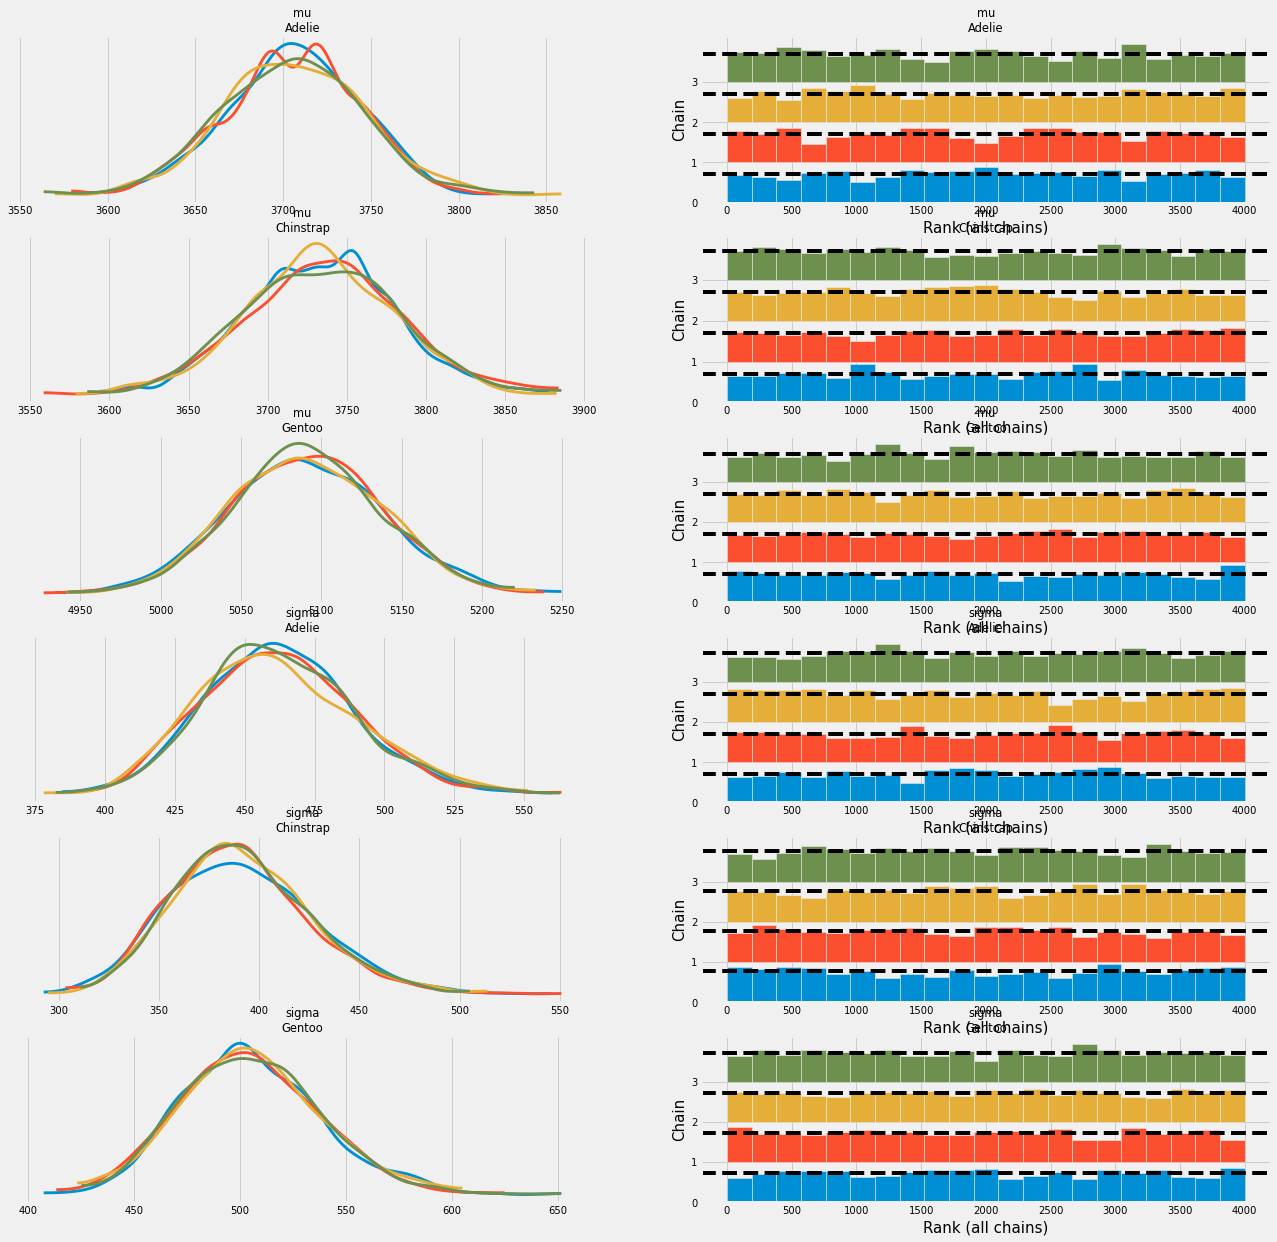

In [54]:
# Plot traces
az.plot_trace(
    inference_data_all_mass, 
    compact=False, 
    figsize=(20, 20),
    divergences="bottom", 
    kind="rank_bars"
)

plt.show()

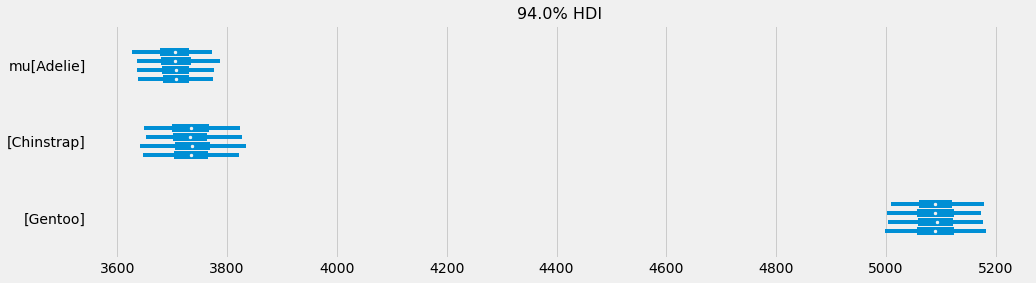

In [59]:
# Compare the species
az.plot_forest(
    inference_data_all_mass,
    figsize=(15, 4),
    var_names='mu'
)
plt.show()

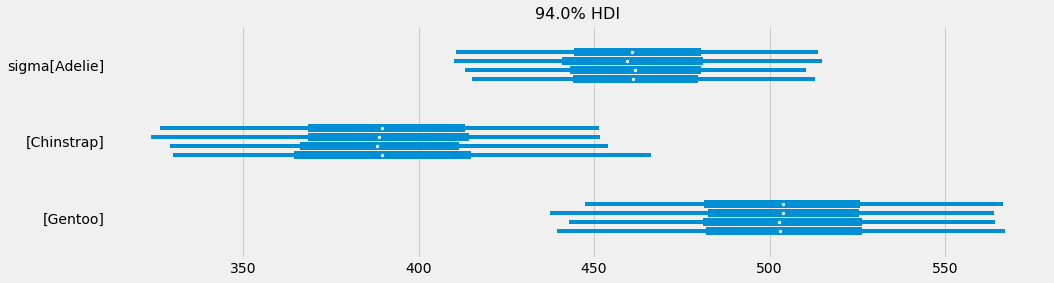

In [60]:
az.plot_forest(
    inference_data_all_mass,
    figsize=(15, 4),
    var_names='sigma'
)
plt.show()